In [1]:
%load_ext autoreload
%autoreload 2
import jax
import jax.numpy as jnp
import numpy as np
from jax.config import config
from gdml_jax.util.datasets import load_md17
from gdml_jax.kernels import rbf, DescriptorKernel, sGDMLKernel
from gdml_jax.models import GDMLPredict, GDMLPredictEnergy
from gdml_jax.solve import solve_closed
from gdml_jax import losses

# enable double precision
config.update("jax_enable_x64", True)

# args
DATA_DIR = 'data/train'
MOLECULE = "ethanol"
N_TRAIN = 100
N_TEST = 200
REG = 1e-10

# data loading
trainset, testset, meta = load_md17(MOLECULE, N_TRAIN, N_TEST, DATA_DIR)
train_x, train_e, train_y = trainset
test_x, test_e, test_y = testset

def loss_from_kernel(basekernel, kernel_kwargs, reg=REG):
    params = solve_closed(basekernel, train_x, train_y, reg=reg, kernel_kwargs=kernel_kwargs, verbose=False)
    force_fn = GDMLPredict(basekernel, train_x)
    preds_y = force_fn(params, test_x)
    energy_fn = GDMLPredictEnergy(basekernel, train_x, train_e, params)
    preds_e = energy_fn(test_x)
    return {
        "force MSE": losses.mse(test_y, preds_y),
        "force MAE": losses.mae(test_y, preds_y),
        "energy MSE": losses.mse(test_e, preds_e),
        "energy MAE": losses.mae(test_e, preds_e),
    }

In [2]:
def gdml_descriptor(r):
    """(N,3) -> (N choose 2)"""
    n_atoms, n_dim = r.shape
    idx1, idx2 = np.triu_indices(n_atoms, k=1)
    pair_fn = lambda ri, rj: 1.0 / jnp.linalg.norm(ri - rj)
    return jax.vmap(lambda i, j: pair_fn(r[i], r[j]))(idx1, idx2)

# sanity-check
gdml_kernel = DescriptorKernel(gdml_descriptor, rbf)
loss_from_kernel(gdml_kernel, {"lengthscale": 10.0})

{'force MSE': DeviceArray(9.19735806, dtype=float64),
 'force MAE': DeviceArray(2.16467254, dtype=float64),
 'energy MSE': DeviceArray(0.7140331, dtype=float64),
 'energy MAE': DeviceArray(0.65582486, dtype=float64)}

In [3]:
def powered_coulomb_descriptor(r, power=1.0):
    """(N,3) -> (N choose 2)"""
    n_atoms, n_dim = r.shape
    idx1, idx2 = np.triu_indices(n_atoms, k=1)
    pair_fn = lambda ri, rj: 1.0 / jnp.linalg.norm(ri - rj) ** power
    return jax.vmap(lambda i, j: pair_fn(r[i], r[j]))(idx1, idx2)

def loss_from_power(power):
    basekernel = DescriptorKernel(powered_coulomb_descriptor, rbf)
    kernel_kwargs = {
        "lengthscale": 10.0,
        "descriptor_kwargs": {"power": power},   
    }
    return loss_from_kernel(basekernel, kernel_kwargs)

ls = []
for power in [0.5, 0.8, 0.9, 0.999, 1.0, 1.001, 1.2, 1.5, 2.0]:
    loss = loss_from_power(power)
    ls += [loss]
    print("power", power, loss["force MSE"], loss["force MAE"], loss["energy MSE"], loss["energy MAE"])

power 0.5 10.629931424135238 2.329693839519871 0.773222969471347 0.6970459661634959
power 0.8 9.002620476284214 2.1324941240081836 0.7352335272738347 0.6709299952288711
power 0.9 8.989997879776471 2.1333137093320658 0.7241179521511433 0.6616349628914759
power 0.999 9.194337973233973 2.16424266147777 0.7141280267399462 0.6558783930882782
power 1.0 9.197358063199518 2.164672543888567 0.714033102375623 0.6558248647490836
power 1.001 9.2003952245211 2.1651033177536707 0.7139382019854533 0.6557712932212598
power 1.2 10.106274211357087 2.282721821859235 0.697452506183975 0.6447484203895875
power 1.5 12.26643859534853 2.517362734895154 0.6824181252897492 0.6364926310559531
power 2.0 17.00503372778464 2.953640016592416 0.6884438284807566 0.647577607406347


In [4]:
powers = np.linspace(0, 2, num=20)
losses_powers = [loss_from_power(power) for power in powers]

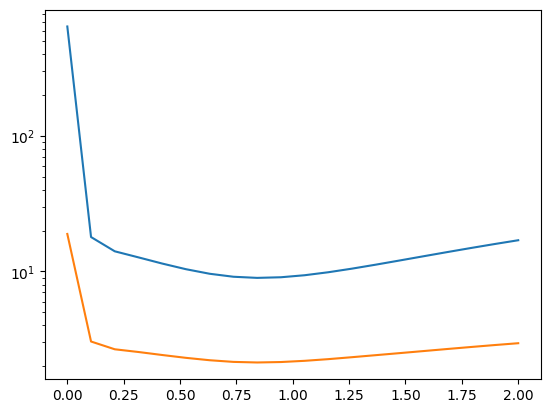

In [5]:
import matplotlib.pyplot as plt
plt.plot(powers, [l["force MSE"] for l in losses_powers])
plt.plot(powers, [l["force MAE"] for l in losses_powers])
plt.yscale("log")

In [6]:
grad_fn = jax.jit(jax.value_and_grad(lambda p: loss_from_power(p)["force MSE"]))
grad_fn(1.0)

(DeviceArray(9.19735777, dtype=float64),
 DeviceArray(3.02863913, dtype=float64, weak_type=True))

In [12]:
import optax

def print_callback(i, loss, params):
    print(i, loss, params)

def fit(loss_fn, params, optimizer, cb=print_callback):

    @jax.jit
    def train_step(params, opt_state):
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss
    
    opt_state = optimizer.init(params)
    for i in range(steps):
        params, opt_state, loss = train_step(params, opt_state)
        cb(i, loss, params)
    
    return params

def loss_fn(params):
    return loss_from_power(params["power"])["force MSE"]

steps = 10
optimizer = optax.adam(1e-2)
params = {"power": 1.0}
fit(loss_fn, params, optimizer)

0 9.19735776798425 {'power': DeviceArray(0.99, dtype=float64)}
1 9.167961937310643 {'power': DeviceArray(0.98002047, dtype=float64)}
2 9.140429273459365 {'power': DeviceArray(0.97007786, dtype=float64)}
3 9.114832580352271 {'power': DeviceArray(0.96019108, dtype=float64)}
4 9.091235500823892 {'power': DeviceArray(0.95038177, dtype=float64)}
5 9.069695368719746 {'power': DeviceArray(0.94067461, dtype=float64)}
6 9.050255332101905 {'power': DeviceArray(0.93109758, dtype=float64)}
7 9.032943862531775 {'power': DeviceArray(0.92168226, dtype=float64)}
8 9.017771570008378 {'power': DeviceArray(0.91246392, dtype=float64)}
9 9.004726362367652 {'power': DeviceArray(0.90348164, dtype=float64)}


{'power': DeviceArray(0.90348164, dtype=float64)}

# Interpolate between two kernels

E.g. at different length scales

In [6]:
for l in [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]:
    print(l, loss_from_kernel(gdml_kernel, {"lengthscale": l}))

2.0 {'force MSE': DeviceArray(18.63398343, dtype=float64), 'force MAE': DeviceArray(3.12104722, dtype=float64), 'energy MSE': DeviceArray(0.76308332, dtype=float64), 'energy MAE': DeviceArray(0.65212201, dtype=float64)}
4.0 {'force MSE': DeviceArray(17.52967506, dtype=float64), 'force MAE': DeviceArray(3.02118867, dtype=float64), 'energy MSE': DeviceArray(0.75144687, dtype=float64), 'energy MAE': DeviceArray(0.64138901, dtype=float64)}
6.0 {'force MSE': DeviceArray(13.73956529, dtype=float64), 'force MAE': DeviceArray(2.6691914, dtype=float64), 'energy MSE': DeviceArray(0.70093563, dtype=float64), 'energy MAE': DeviceArray(0.61753091, dtype=float64)}
8.0 {'force MSE': DeviceArray(10.80010362, dtype=float64), 'force MAE': DeviceArray(2.3588432, dtype=float64), 'energy MSE': DeviceArray(0.73259648, dtype=float64), 'energy MAE': DeviceArray(0.64399561, dtype=float64)}
10.0 {'force MSE': DeviceArray(9.19735806, dtype=float64), 'force MAE': DeviceArray(2.16467254, dtype=float64), 'energy MS

In [3]:
from gdml_jax.kernels import sGDMLKernel
from gdml_jax.util.datasets import get_symmetries
perms = get_symmetries(MOLECULE)
sgdml_kernel = sGDMLKernel(meta['shape'], perms=perms)
sgdml_kernel(train_x[0], train_x[1])

DeviceArray(0.942042, dtype=float64)

In [8]:
for l in [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]:
    print(l, loss_from_kernel(sgdml_kernel, {"lengthscale": l}))

2.0 {'force MSE': DeviceArray(2.2840402, dtype=float64), 'force MAE': DeviceArray(1.0685905, dtype=float64), 'energy MSE': DeviceArray(0.06590669, dtype=float64), 'energy MAE': DeviceArray(0.17819039, dtype=float64)}
4.0 {'force MSE': DeviceArray(1.65460302, dtype=float64), 'force MAE': DeviceArray(0.90956195, dtype=float64), 'energy MSE': DeviceArray(0.07960195, dtype=float64), 'energy MAE': DeviceArray(0.21882415, dtype=float64)}
6.0 {'force MSE': DeviceArray(2.31370029, dtype=float64), 'force MAE': DeviceArray(1.07569003, dtype=float64), 'energy MSE': DeviceArray(0.16544809, dtype=float64), 'energy MAE': DeviceArray(0.32588118, dtype=float64)}
8.0 {'force MSE': DeviceArray(3.30399339, dtype=float64), 'force MAE': DeviceArray(1.29246243, dtype=float64), 'energy MSE': DeviceArray(0.2673612, dtype=float64), 'energy MAE': DeviceArray(0.40958653, dtype=float64)}
10.0 {'force MSE': DeviceArray(4.14608582, dtype=float64), 'force MAE': DeviceArray(1.45083987, dtype=float64), 'energy MSE': D

In [4]:
def mixed_kappa(x1, x2, lengthscale1, lengthscale2, tradeoff):
    k1 = rbf(x1, x2, lengthscale=lengthscale1)
    k2 = rbf(x1, x2, lengthscale=lengthscale2)
    return (1 - tradeoff) * k1 + tradeoff * k2

mixed_kernel = sGDMLKernel(meta['shape'], kappa=mixed_kappa, perms=perms)

In [10]:
for l in [2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 18.0, 20.0]:
    print(l, loss_from_kernel(mixed_kernel, {"lengthscale1": 4.0, "lengthscale2": l, "tradeoff": 0.5}))

2.0 {'force MSE': DeviceArray(2.12708693, dtype=float64), 'force MAE': DeviceArray(1.03073715, dtype=float64), 'energy MSE': DeviceArray(0.06224545, dtype=float64), 'energy MAE': DeviceArray(0.17917003, dtype=float64)}
4.0 {'force MSE': DeviceArray(1.65460302, dtype=float64), 'force MAE': DeviceArray(0.90956195, dtype=float64), 'energy MSE': DeviceArray(0.07960195, dtype=float64), 'energy MAE': DeviceArray(0.21882415, dtype=float64)}
6.0 {'force MSE': DeviceArray(1.73323048, dtype=float64), 'force MAE': DeviceArray(0.93052039, dtype=float64), 'energy MSE': DeviceArray(0.09132694, dtype=float64), 'energy MAE': DeviceArray(0.23813276, dtype=float64)}
8.0 {'force MSE': DeviceArray(1.74534873, dtype=float64), 'force MAE': DeviceArray(0.93379489, dtype=float64), 'energy MSE': DeviceArray(0.09300342, dtype=float64), 'energy MAE': DeviceArray(0.24081406, dtype=float64)}
10.0 {'force MSE': DeviceArray(1.7472089, dtype=float64), 'force MAE': DeviceArray(0.93431416, dtype=float64), 'energy MSE':

In [11]:
for t in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    print(t, loss_from_kernel(mixed_kernel, {"lengthscale1": 4.0, "lengthscale2": 8.0, "tradeoff": t}))

# Gradients w.r.t. kernel parameters

In [5]:
@jax.jit
def loss_fn(l):
    kernel_kwargs = {"lengthscale1": 4.0, "lengthscale2": l, "tradeoff": 0.5}
    return loss_from_kernel(mixed_kernel, kernel_kwargs)["force MSE"]

fwd_grad_fn = jax.jit(jax.jacfwd(loss_fn))
print(fwd_grad_fn(4.0))
rev_grad_fn = jax.jit(jax.grad(loss_fn))
print(rev_grad_fn(4.0))

0.06299408183381465
0.06299408075767587


In [6]:
%timeit jax.block_until_ready(loss_fn(4.0))
%timeit jax.block_until_ready(fwd_grad_fn(4.0))
%timeit jax.block_until_ready(rev_grad_fn(4.0))

2.55 s ± 137 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.71 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
3.34 s ± 124 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
